In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from numba import jit
from scipy.linalg import eigh_tridiagonal
plt.style.use('dark_background')

Time dependent schrodinger equation

$$
i\hbar\frac{\partial}{\partial t}\psi(x,t) = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\psi(x,t) + V(x)\psi(x,t)
$$

Now assume $\psi(0,t)=\psi(L,t) = 0$

Let
- $x' = x/L$
- $t' = \frac{t}{mL^2}$
- $V' = mL^2V$
- $\hbar = 1$

Then
\begin{align*}
imL^2\hbar\frac{\partial}{\partial t}\psi &= -\frac{1}{2}\hbar^2L^2\frac{\partial^2}{\partial x^2}\psi + mL^2V\psi\\
i\frac{\partial}{\partial t'}\psi &= -\frac{1}{2}\frac{\partial^2}{\partial x'^2}\psi+V'\psi
\end{align*}

### Technique 1: Finite Difference
$$
i\frac{\psi(x', t' +\Delta t')-\psi(x',t')}{\Delta t'} = -\frac{1}{2}\frac{\psi(x'+\Delta x',t')-2\psi(x',t')+\psi(x'-\Delta x',t')}{\Delta x'^2}+V'\psi(x',t')
$$
$$
\psi(x', t' +\Delta t') = \left(1 - i\Delta t' V' - i\frac{\Delta t'}{\Delta x'^2}\right)\psi(x',t') + \frac{i}{2}\frac{\Delta t'}{\Delta x'^2}\left(\psi(x'+\Delta x',t')+\psi(x'-\Delta x',t')\right)
$$

In [3]:
Nx = 301
Nt = 4001
dx = 1/(Nx-1)
dt = 1e-7
x = np.linspace(0,1,Nx)

In [4]:
dt/dx**2   # this value must be small

0.008999999999999998

Potential we use now is

$$
V(x) = -\text{Normal}(x, \mu=L/2, \sigma=L/20) =  -10^4\exp\left(\frac{-(x-L/2)^2}{2(L/20)^2}\right)
$$

In [5]:
mu, sigma = 1/3, 1/20
psi0 = np.exp(-(x-mu)**2/(2*sigma**2))
psi0 /= np.sqrt(np.sum(psi0**2*dx))
# V = -1e4*np.exp(-(x-mu)**2/(2*sigma**2))
V = 1e2*((x<0.4)+(x>0.6))

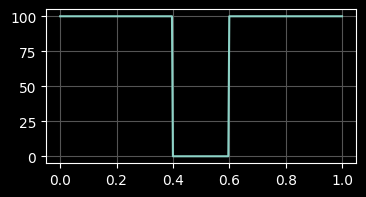

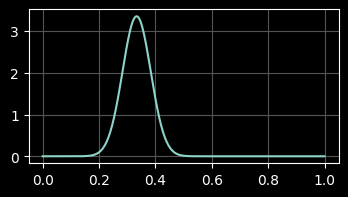

In [6]:
plt.figure(figsize=(4,2))
plt.plot(x,V)
plt.grid(color='#545454')
plt.figure(figsize=(4,2))
plt.plot(x,psi0)
plt.grid(color='#545454')

In [7]:
psi = np.zeros([Nt, Nx])
psi[0] = psi0

In [8]:
@jit("c16[:,:](c16[:,:])",nopython=True, nogil=True)
def compute_psi(psi):
    for t in range(0, Nt-1):
        for i in range(1, Nx-1):
            psi[t+1, i] = (1-1j*dt*(V[i]+1/dx**2))*psi[t,i] + 1j/2*dt/dx**2*(psi[t,i+1]+psi[t,i-1])
        area = np.sum(np.absolute(psi[t+1])**2)*dx
        psi[t+1,:]/=area
    return psi

In [9]:
psi_m1 = compute_psi(psi.astype(complex))

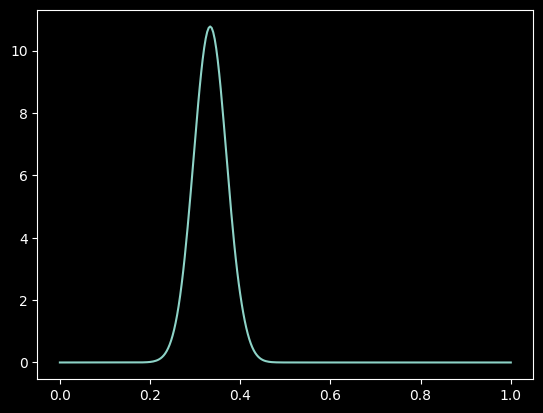

In [10]:
plt.plot(x,np.absolute(psi_m1[8000])**2)

### Technique 2: Eigenstate evolution

$$
\psi(x,t) = \sum_{j=0}^\infty c_j\psi_j(x)e^{-iE_jt}\qquad c_j = \int_{-\infty}^\infty\psi(x,0)\psi_j^*(x)dx
$$

Find out $\psi_j$ with method just like before:

$$
\begin{pmatrix}
d_1 & e & 0 & \cdots & 0\\
e & d_2 & e & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots & \vdots\\
0 & \cdots & 0 & e & d_{n-1}
\end{pmatrix}\begin{pmatrix}
\phi_1\\
\phi_2\\
\vdots\\
\phi_{n-1}
\end{pmatrix} = \frac{E'}{\hbar^2}\begin{pmatrix}\phi_1\\\phi_2\\\vdots\\\phi_{n-1}\end{pmatrix}
$$

where $E'=mL^2 E$, $d_i = V'(x_i) + \frac{1}{\Delta x'^2}$ and $e = -\frac{1}{2\Delta x'^2}$

In [11]:
d = V[1:-1] + 1/dx**2
e = -1/2/dx**2 * np.ones(len(d)-1)
lam, v = eigh_tridiagonal(d,e)     ## lambda is the E'

In [12]:
psi_j = np.pad(v.T,((1,1),(1,1)),mode='constant')
E = np.pad(lam,(1,1),mode='constant')
c_j = psi_j@psi0
def psi_m2(t):
    return psi_j.T@(c_j*np.exp(-1j*E*t*dt))

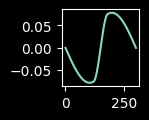

In [13]:
plt.figure(figsize=(1,1))
plt.plot(psi_j[2])

e:\programmeFiles\python9\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


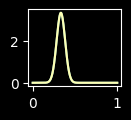

In [14]:
plt.figure(figsize=(1.2,1))
plt.plot(x,psi_m2(1000))
plt.plot(x,psi0)

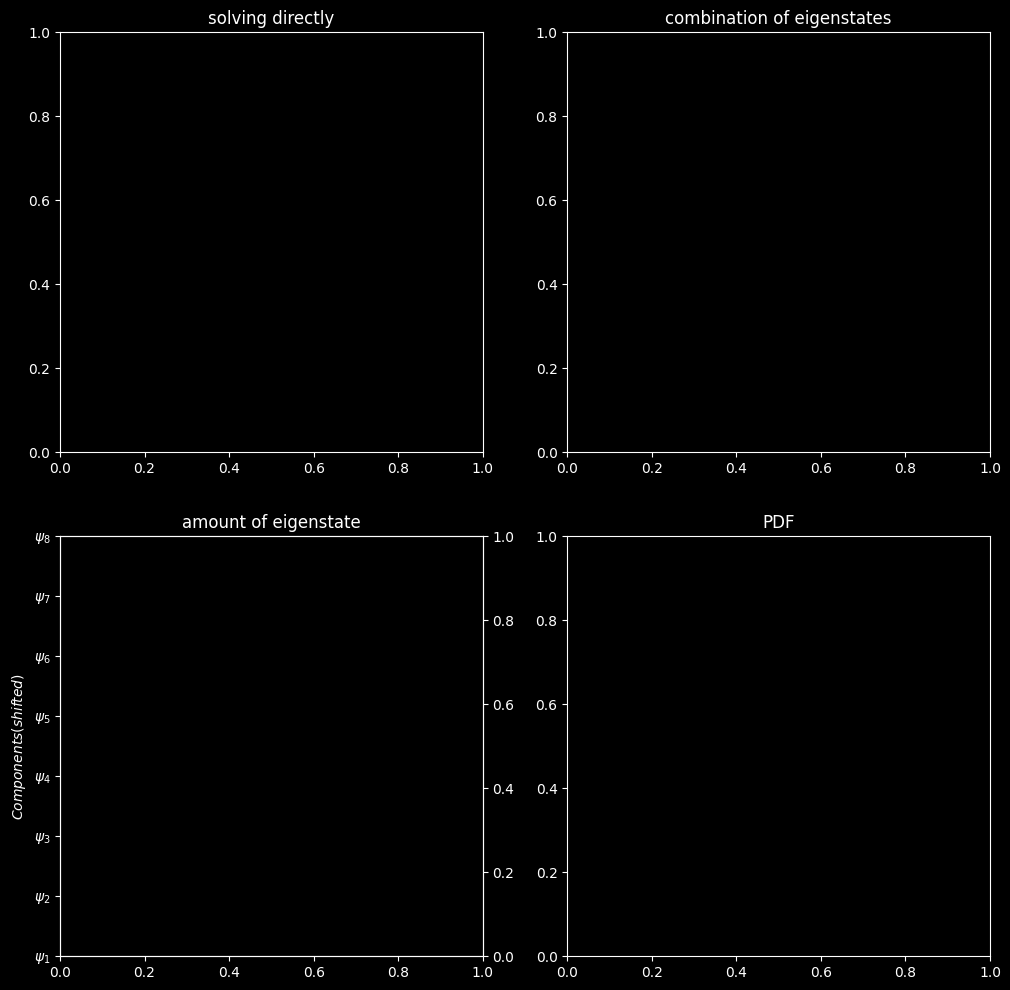

In [15]:
fig, axs = plt.subplots(2,2)
axs = axs.flatten()
fig.set_figwidth(12)
fig.set_figheight(12)
noEigen = 9
sep = 3
axs[0].set_title('solving directly')
axs[1].set_title('combination of eigenstates')
axs[2].set_title('amount of eigenstate')
axs[2].set_ylabel('$Components (shifted)$')
axs[2].set_yticks(range(0,(noEigen-1)*sep,sep),[f'$\psi_{i}$' for i in range(1,noEigen)])
axs[3].set_title('PDF')
ax_potential = axs[2].twinx()
total_frames = 300
multiplier = 800
def animate(i):
    for ax in axs:
        ax.clear()
    ax_potential.clear()
    i = i*multiplier
    axs[0].plot(x,np.real(psi_m1[i]))
    axs[0].plot(x,np.imag(psi_m1[i]), '--')
    result2 = psi_m2(i)
    axs[1].plot(x,np.real(result2))
    axs[1].plot(x,np.imag(result2), '--')
    for n in range(1,noEigen):
        curve = c_j[n]*np.exp(-1j*E[n]*i*dt)*psi_j[n]
        axs[2].plot(x,np.real(curve)+sep*n-sep,color='#EF4336')
        axs[2].plot(x,np.imag(curve)+sep*n-sep,'--',color='#79BA7B')
    ax_potential.plot(x,V,color='#545454')
    axs[3].plot(x,np.absolute(result2)**2)
    print(f'{int(i/multiplier)}/{total_frames}',end='\r')
    
#ani = animation.FuncAnimation(fig,animate,total_frames)
#ani.save('wavefunc4.gif','pillow',30)
